<a href="https://colab.research.google.com/github/Stelios7sty/ML-Project_2022/blob/main/Original_Distracted_Driver_Project_Rst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Distracted Driver Detection**

## **Machine Learning with Project 8635 - resit**

# *Project Description:*

In this competition you are given driver images, each taken in a car with a driver doing something in the car (texting, eating, talking on the phone, makeup, reaching behind, etc). Your goal is to predict the likelihood of what the driver is doing in each picture.

The 10 classes to predict are:
* c0: safe driving 
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### How to download the data from kaggle:


1. Go to your kaggle account and make sure other tokens are expired by clicking "Expire Other Tokens"
2. Then Download new APi Token by clicking "New APi Token"
3. Upload the file you have downloaded from Kaggle below.



In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"steliosstylianou7","key":"63ab0121646dc63b24d6de2397d86ec0"}'}

4. Next run the following codes. 

In [7]:

! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39          10337       1415  0.9375           
victorsoeiro/netflix-tv-shows-and-movies                              Netflix TV Shows and Movies                        2MB  2022-05-15 00:01:23           2392         79  1.0              
mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           6920        176  1.0              
muratkokludataset/acoustic-extinguisher-fire-

In [9]:
! kaggle competitions download -c state-farm-distracted-driver-detection
! mkdir distracted-driver-detection-unzip
! unzip state-farm-distracted-driver-detection.zip -d distracted-driver-detection-unzip

Streaming output truncated to the last 5000 lines.
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_56636.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_56661.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_56699.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_56717.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_56724.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_56768.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_56779.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_56849.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_56899.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_56938.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_5706.jpg  
  inflating: distracted-driver-detection-unzip/imgs/train/c7/img_57076.jpg  
  inflating: distracted-dr

### Make sure that the datasets are loaded. 

In [2]:
import os

data_dir = "/content/distracted-driver-detection-unzip"
os.listdir(data_dir)



['sample_submission.csv', 'driver_imgs_list.csv', 'imgs']

In [3]:
import pandas as pd
data = pd.read_csv("/content/distracted-driver-detection-unzip/driver_imgs_list.csv")
data.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
by_drivers = data.groupby('subject') 
unique_drivers = by_drivers.groups.keys() 


print('unique drivers: ',len(unique_drivers)) 

print('mean of images: ', round(data.groupby('subject').count()['classname'].mean()))

unique drivers:  26
mean of images:  862


In [5]:
category_number = len(data['classname'].unique())
print("The categories are: ", category_number)

data.columns

The categories are:  10


Index(['subject', 'classname', 'img'], dtype='object')

### Check the images by categories

In [6]:
import matplotlib.pyplot as plt
import plotly.express as px

px.histogram(data, x="classname", color="classname", title="Number of images by categories ")

In [7]:
from skimage import io
from skimage import color
from dask.array.image import imread
import cv2

img = cv2.imread('/content/distracted-driver-detection-unzip/imgs/train/c0/img_25094.jpg')
img.shape

(480, 640, 3)

## Libraries

In [8]:
import cv2
import numpy as np 
import pandas as pd 
import os
from keras.utils.np_utils import to_categorical 
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from glob import glob
from tensorflow.keras.applications import VGG16,EfficientNetB3
from tensorflow import keras

In [9]:
# getting image and reducing the size of it so I can use it while loading the data 
def get_image(path, img_rows, img_cols, color_type=3):
    img = cv2.imread(path,1)
    resized_img = cv2.resize(img, (img_rows, img_cols)) 
    return resized_img 

In [10]:
from glob import glob

num_of_classes = 10

#method for getting training images and labels 
def get_training_data(img_rows, img_cols, color_type=3): 
    train_images = [] 
    train_labels = []
    for classed in range(num_of_classes):
        print('Reading images from directory c{}'.format(classed))
        files = glob(os.path.join('/content/distracted-driver-detection-unzip/imgs/train/c' + str(classed), '*.jpg'))
        for file in files:
            img = get_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels 

## Normalisation of Data

In [11]:
## convert string labels to numbers
def read_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = get_training_data(img_rows, img_cols, color_type)
    enc = LabelEncoder()                        
    conversion = enc.fit_transform(labels)                 
    y = keras.utils.to_categorical(conversion) #one hot encoding for the labels                        
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # spliting the data to train and test data
    x_train = np.array(x_train).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test).reshape(-1,img_rows,img_cols,color_type)
    return x_train, x_test, y_train, y_test

In [12]:
def get_testing_data(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('/content/distracted-driver-detection-unzip/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in files:
        if total >= size or total >= files_size:
            break
        file_base = file.split(os.path.sep)[-1]
        img = get_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

In [13]:
def read_normalize_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = get_testing_data(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [14]:
test_data = pd.read_csv('/content/distracted-driver-detection-unzip/sample_submission.csv')
test_data.shape

(79726, 11)

In [15]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Reading the data with the use of methods above and in the same time the normalaization

In [16]:
img_rows = 64 # dimension of images
img_cols = 64
color_type = 3
test_samples = test_data.shape[0]

# loading train images
with tf.device('/device:GPU:0'):
  x_train, x_test, y_train, y_test = read_normalize_train_data(img_rows, img_cols, color_type)

Reading images from directory c0
Reading images from directory c1
Reading images from directory c2
Reading images from directory c3
Reading images from directory c4
Reading images from directory c5
Reading images from directory c6
Reading images from directory c7
Reading images from directory c8
Reading images from directory c9


In [17]:
with tf.device('/device:GPU:0'):
  test_files, test_targets = read_normalize_test_data(test_samples, img_rows, img_cols, color_type)

In [18]:
classes = {'c0': 'Safe driving', 
            'c1': 'Texting - right', 
            'c2': 'Talking on the phone - right', 
            'c3': 'Texting - left', 
            'c4': 'Talking on the phone - left', 
            'c5': 'Operating the radio', 
            'c6': 'Drinking', 
            'c7': 'Reaching behind', 
            'c8': 'Hair and makeup', 
            'c9': 'Talking to passenger'}

### Creating the CNN model

In [19]:
def create_CNN_model():
    model = Sequential()

  
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

  
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))


    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [20]:
model = create_CNN_model()

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                        

### ETA

In [21]:
with tf.device('/device:GPU:0'):
  history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15,batch_size=40, verbose=1)

Epoch 1/15
449/449 [==============================] - 22s 24ms/step - loss: 1.2836 - accuracy: 0.5787 - val_loss: 0.4232 - val_accuracy: 0.8562
Epoch 2/15
449/449 [==============================] - 11s 24ms/step - loss: 0.3403 - accuracy: 0.8902 - val_loss: 0.1952 - val_accuracy: 0.9371
Epoch 3/15
449/449 [==============================] - 10s 23ms/step - loss: 0.1974 - accuracy: 0.9379 - val_loss: 0.0924 - val_accuracy: 0.9699
Epoch 4/15
449/449 [==============================] - 10s 23ms/step - loss: 0.1685 - accuracy: 0.9446 - val_loss: 0.1091 - val_accuracy: 0.9652
Epoch 5/15
449/449 [==============================] - 13s 29ms/step - loss: 0.1271 - accuracy: 0.9599 - val_loss: 0.0486 - val_accuracy: 0.9851
Epoch 6/15
449/449 [==============================] - 10s 22ms/step - loss: 0.0944 - accuracy: 0.9705 - val_loss: 0.0455 - val_accuracy: 0.9860
Epoch 7/15
449/449 [==============================] - 10s 22ms/step - loss: 0.1186 - accuracy: 0.9628 - val_loss: 0.1176 - val_accuracy:

### Plot for Accuracy Vs Loss

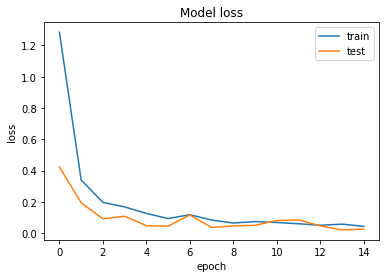

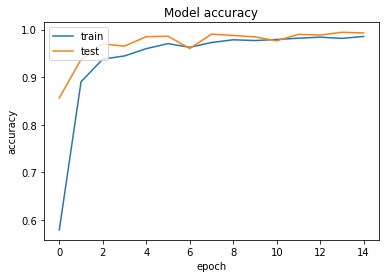

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Calculate overall accuracy for the model

In [23]:
score1 = model.evaluate(x_test, y_test, verbose=1)
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

141/141 [==============================] - 1s 6ms/step - loss: 0.0267 - accuracy: 0.9929
Loss:  0.026673106476664543
Accuracy:  99.28650856018066  %


In [24]:
predictions = model.predict(test_files, batch_size=40, verbose=0)

### Run Testings

Predicted: Operating the radio
<------------------------------->



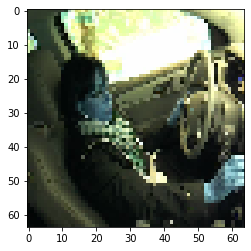

Predicted: Operating the radio
<------------------------------->



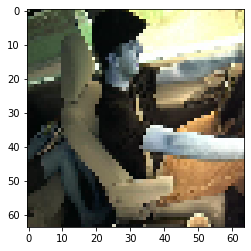

Predicted: Safe driving
<------------------------------->



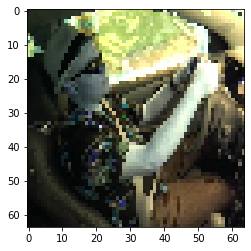

Predicted: Hair and makeup
<------------------------------->



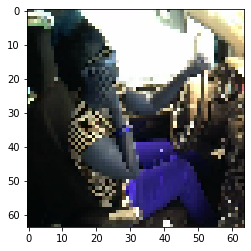

Predicted: Texting - left
<------------------------------->



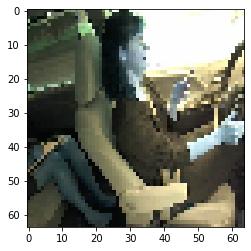

Predicted: Texting - left
<------------------------------->



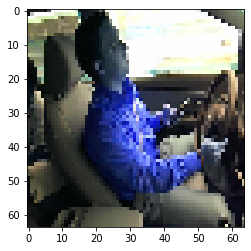

Predicted: Talking to passenger
<------------------------------->



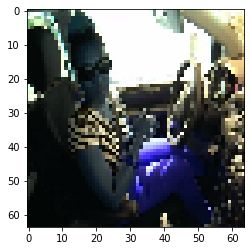

Predicted: Reaching behind
<------------------------------->



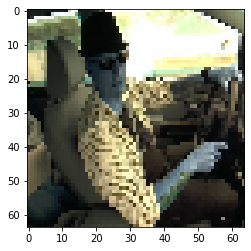

Predicted: Drinking
<------------------------------->



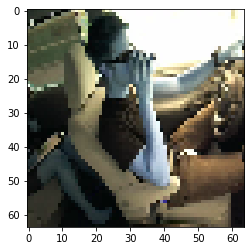

Predicted: Reaching behind
<------------------------------->



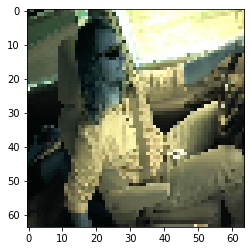

In [25]:
for i in range(10):
    img = test_files[i]
    plt.imshow(img, cmap='gray')

   # print('Y prediction: {}'.format(predictions[i]))
    print('Predicted: {}'.format(classes.get('c{}'.format(np.argmax(predictions[i])))))
    print("<------------------------------->")
    print()
    plt.show()

In [85]:
random_test_id = np.random.randint(0, len(test_files)-1)
print('the randomly selected test_id: '+str(random_test_id))

the randomly selected test_id: 5170


In [72]:
#current_test_img = test_files[random_test_id,:,:,0]

getting the current test frame


Predicted: Safe driving


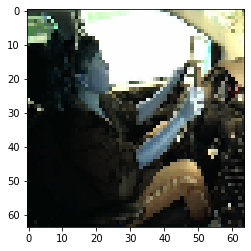

In [86]:
img1 = test_files[random_test_id]
see_graph = predictions[random_test_id]
see_graph
plt.imshow(img1, cmap='gray')
print('Predicted: {}'.format(classes.get('c{}'.format(np.argmax(see_graph)))))
plt.show()

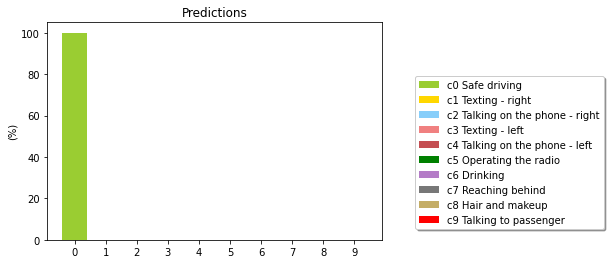

In [104]:
name_of_classes = {'c0 Safe driving': 'Safe driving', 
            'c1 Texting - right': 'Texting - right', 
            'c2 Talking on the phone - right': 'Talking on the phone - right', 
            'c3 Texting - left': 'Texting - left', 
            'c4 Talking on the phone - left': 'Talking on the phone - left', 
            'c5 Operating the radio': 'Operating the radio', 
            'c6 Drinking': 'Drinking', 
            'c7 Reaching behind': 'Reaching behind', 
            'c8 Hair and makeup': 'Hair and makeup', 
            'c9 Talking to passenger': 'Talking to passenger'}
c = np.arange(num_of_classes)
color_set = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral',
        '#C44E52', 'green', '#B47CC7','#777777','#C4AD66','red', 
                   ]

colors = color_set[:num_of_classes]
fig, ax = plt.subplots()
_bar = ax.bar(c, 100*see_graph, color=colors)
ax.legend(_bar, (name_of_classes), loc=(1.1, 0.05), shadow=True, borderaxespad=10)
ax.set_ylabel('(%)')
ax.set_title('Predictions')
ax.set_xticks(c)

plt.show()



### Creating the final submission file

In [26]:
results = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
results.loc[:, 'img'] = pd.Series(test_targets, index=results.index)
    
submission_file = os.path.join('submission' + '.csv')
    
results.to_csv(submission_file, index=False)

In [27]:
test_csv = pd.read_csv('./submission.csv')
test_csv

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,img
0,7.801979e-17,2.959943e-24,2.487952e-17,1.928487e-13,2.051839e-12,1.000000e+00,1.034845e-16,3.062729e-12,6.069074e-14,8.276301e-14,img_1.jpg
1,1.047326e-11,7.378655e-17,2.022515e-15,5.247444e-12,7.373208e-14,1.000000e+00,5.446689e-14,6.780347e-11,8.124747e-13,8.437534e-12,img_10.jpg
2,9.969125e-01,1.416946e-05,1.080686e-06,2.106968e-03,4.867839e-07,6.923732e-06,6.192629e-08,5.636956e-07,1.044741e-05,9.468382e-04,img_100.jpg
3,3.565798e-04,4.368536e-07,3.608174e-04,3.109518e-07,1.978068e-04,7.847345e-04,1.521220e-05,2.259197e-04,9.980140e-01,4.411520e-05,img_1000.jpg
4,1.095268e-07,1.141589e-10,5.039362e-09,9.998466e-01,2.831799e-05,3.683235e-05,5.313140e-10,1.772121e-07,8.737858e-05,6.006174e-07,img_100000.jpg
...,...,...,...,...,...,...,...,...,...,...,...
79721,9.679298e-02,2.802680e-01,2.837710e-02,3.100280e-04,6.401122e-03,9.915279e-02,3.448822e-02,4.201776e-01,2.768811e-02,6.344077e-03,img_99994.jpg
79722,4.914696e-05,1.050678e-06,1.425142e-07,9.999453e-01,1.193053e-06,1.768379e-06,1.061574e-06,2.067712e-08,1.322155e-08,3.318767e-07,img_99995.jpg
79723,1.220949e-07,4.413559e-09,1.607018e-08,2.342067e-07,9.999983e-01,3.544402e-08,2.927148e-07,8.111472e-07,1.315800e-07,1.264735e-07,img_99996.jpg
79724,6.451473e-09,4.867092e-11,2.580859e-03,7.269977e-11,4.707288e-06,9.495974e-07,9.973578e-01,1.885477e-06,5.290232e-05,8.154959e-07,img_99998.jpg
